In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd


# Define the neural network architecture
class ParallelNN(nn.Module):
    def __init__(self, input1_size, hidden_size, num_classes):
        super(ParallelNN, self).__init__()

        # Define the first pipeline
        self.pipeline1 = nn.Sequential(
            nn.Linear(input1_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, hidden_size)
        )

        # Define the final classification layer
        self.classification = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x1):
        out1 = self.pipeline1(x1)

        # Apply the final classification layer
        final_out = self.classification(out1)
        return final_out

# Define the input sizes, hidden size, and number of classes
#input1_size = 10  # Change this to match the number of features in your first dataset
#input2_size = 8   # Change this to match the number of features in your second dataset
#hidden_size = 64
#num_classes = 3   # Change this to match the number of classes in your classification task

# Initialize the model
#model = ParallelNN(input1_size, input2_size, hidden_size, num_classes)

# Define your loss function and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [2]:
from sklearn.preprocessing import QuantileTransformer

# Load the data from a CSV file
NMR_csv_name = '../data/PD_Serum_Metabolomics_Final_NMR.csv'
MS_csv_name = '../data/preprocessed_data_PD.csv'

NMR_data = pd.read_csv(NMR_csv_name)
MS_data = pd.read_csv(MS_csv_name)

# Labels are first column of MS data
# Remove 305h row from MS data, because it is missing from NMR data
data1 = torch.tensor(NMR_data.values, dtype=torch.float32)
data2 = torch.tensor(MS_data.drop(index=305).iloc[:, 1:].values, dtype=torch.float32)
labels = torch.tensor(MS_data.drop(index=305).iloc[:, 0].values, dtype=torch.long)

# Concatenate the data
data = torch.cat((data1, data2), dim=1)

# Normalize the data
scaler = QuantileTransformer()
data = torch.tensor(scaler.fit_transform(data), dtype=torch.float32)

# Define model, loss function, and optimizer
model = ParallelNN(input1_size=data.shape[1], hidden_size=32, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
k_folds = 5

# Prepare data loaders
dataset = TensorDataset(data, labels)
train_set, val_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
sampler = torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=1000)
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=12, shuffle=False)

# Training loop
def train(model, dataloader, criterion, optimizer, best_loss):
    pbar = tqdm(dataloader)
    correct = 0
    running_loss = 0
    

    for (data1, labels) in pbar:
        model.train()


        optimizer.zero_grad()
        outputs = model(data1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * data1.size(0)

        loss.backward()
        optimizer.step()

        # correct += (outputs.argmax(dim=1) == labels).float().sum()
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        accuracy = correct / 1000 # Used in sampling

        
        # Validation loop
        val_loss = 0
        val_accuracy = 0
        model.eval()

        with torch.no_grad():
            for (data1_v, labels_v) in val_loader:

                outputs = model(data1_v)
                loss = criterion(outputs, labels_v)
                val_loss += loss.item()
                val_accuracy += (outputs.argmax(dim=1) == labels_v).float().sum()
         
        pbar.set_description(f"Loss: {running_loss / 1000:.4f}, Accuracy: {accuracy:.4f}")

    val_loss /= len(val_loader)
    val_accuracy /= len(val_set)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_one_pipeline_PD.pth')

    torch.save(model.state_dict(), 'latest_model_one_pipeline_PD.pth')

    return val_loss, val_accuracy, running_loss / 1000, accuracy
        

/Users/franky/Downloads/445-env/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(


Epoch 1/30


Loss: 0.5901, Accuracy: 0.6820: 100%|██████████| 32/32 [00:01<00:00, 21.28it/s]


Validation Loss: 1.3016, Validation Accuracy: 0.4923
Epoch 2/30


Loss: 0.2491, Accuracy: 0.9020: 100%|██████████| 32/32 [00:01<00:00, 22.32it/s]


Validation Loss: 1.7840, Validation Accuracy: 0.5077
Epoch 3/30


Loss: 0.2077, Accuracy: 0.9140: 100%|██████████| 32/32 [00:01<00:00, 22.03it/s]


Validation Loss: 0.8920, Validation Accuracy: 0.7385
Epoch 4/30


Loss: 0.0902, Accuracy: 0.9690: 100%|██████████| 32/32 [00:01<00:00, 22.24it/s]


Validation Loss: 1.7185, Validation Accuracy: 0.6462
Epoch 5/30


Loss: 0.1606, Accuracy: 0.9390: 100%|██████████| 32/32 [00:01<00:00, 22.84it/s]


Validation Loss: 0.7486, Validation Accuracy: 0.7231
Epoch 6/30


Loss: 0.0932, Accuracy: 0.9690: 100%|██████████| 32/32 [00:01<00:00, 22.79it/s]


Validation Loss: 0.7343, Validation Accuracy: 0.7385
Epoch 7/30


Loss: 0.0621, Accuracy: 0.9810: 100%|██████████| 32/32 [00:01<00:00, 22.33it/s]


Validation Loss: 0.7717, Validation Accuracy: 0.7692
Epoch 8/30


Loss: 0.0363, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 22.57it/s]


Validation Loss: 0.7400, Validation Accuracy: 0.7692
Epoch 9/30


Loss: 0.0334, Accuracy: 0.9910: 100%|██████████| 32/32 [00:01<00:00, 22.84it/s]


Validation Loss: 0.7819, Validation Accuracy: 0.7692
Epoch 10/30


Loss: 0.0265, Accuracy: 0.9940: 100%|██████████| 32/32 [00:01<00:00, 20.23it/s]


Validation Loss: 0.7960, Validation Accuracy: 0.7538
Epoch 11/30


Loss: 0.0240, Accuracy: 0.9960: 100%|██████████| 32/32 [00:01<00:00, 20.54it/s]


Validation Loss: 0.7821, Validation Accuracy: 0.7846
Epoch 12/30


Loss: 0.0205, Accuracy: 0.9960: 100%|██████████| 32/32 [00:01<00:00, 21.24it/s]


Validation Loss: 0.8214, Validation Accuracy: 0.7692
Epoch 13/30


Loss: 0.0171, Accuracy: 0.9980: 100%|██████████| 32/32 [00:01<00:00, 19.56it/s]


Validation Loss: 0.8058, Validation Accuracy: 0.7692
Epoch 14/30


Loss: 0.0225, Accuracy: 0.9940: 100%|██████████| 32/32 [00:01<00:00, 19.20it/s]


Validation Loss: 0.8148, Validation Accuracy: 0.7538
Epoch 15/30


Loss: 0.0285, Accuracy: 0.9910: 100%|██████████| 32/32 [00:01<00:00, 20.98it/s]


Validation Loss: 0.8321, Validation Accuracy: 0.7692
Epoch 16/30


Loss: 0.0414, Accuracy: 0.9910: 100%|██████████| 32/32 [00:01<00:00, 19.59it/s]


Validation Loss: 0.8420, Validation Accuracy: 0.7538
Epoch 17/30


Loss: 0.0171, Accuracy: 0.9950: 100%|██████████| 32/32 [00:01<00:00, 21.40it/s]


Validation Loss: 0.8004, Validation Accuracy: 0.7846
Epoch 18/30


Loss: 0.0227, Accuracy: 0.9930: 100%|██████████| 32/32 [00:01<00:00, 23.04it/s]


Validation Loss: 0.8178, Validation Accuracy: 0.8000
Epoch 19/30


Loss: 0.0183, Accuracy: 0.9960: 100%|██████████| 32/32 [00:01<00:00, 21.98it/s]


Validation Loss: 0.8100, Validation Accuracy: 0.7538
Epoch 20/30


Loss: 0.0157, Accuracy: 0.9950: 100%|██████████| 32/32 [00:01<00:00, 22.30it/s]


Validation Loss: 0.8015, Validation Accuracy: 0.7692
Epoch 21/30


Loss: 0.0198, Accuracy: 0.9970: 100%|██████████| 32/32 [00:01<00:00, 21.09it/s]


Validation Loss: 0.8083, Validation Accuracy: 0.7692
Epoch 22/30


Loss: 0.0196, Accuracy: 0.9960: 100%|██████████| 32/32 [00:01<00:00, 21.36it/s]


Validation Loss: 0.8207, Validation Accuracy: 0.7692
Epoch 23/30


Loss: 0.0212, Accuracy: 0.9950: 100%|██████████| 32/32 [00:01<00:00, 19.48it/s]


Validation Loss: 0.7921, Validation Accuracy: 0.7846
Epoch 24/30


Loss: 0.0197, Accuracy: 0.9940: 100%|██████████| 32/32 [00:01<00:00, 22.09it/s]


Validation Loss: 0.7901, Validation Accuracy: 0.7692
Epoch 25/30


Loss: 0.0220, Accuracy: 0.9950: 100%|██████████| 32/32 [00:01<00:00, 19.26it/s]


Validation Loss: 0.7944, Validation Accuracy: 0.7846
Epoch 26/30


Loss: 0.0286, Accuracy: 0.9870: 100%|██████████| 32/32 [00:01<00:00, 18.74it/s]


Validation Loss: 0.8053, Validation Accuracy: 0.7692
Epoch 27/30


Loss: 0.0217, Accuracy: 0.9940: 100%|██████████| 32/32 [00:01<00:00, 20.94it/s]


Validation Loss: 0.8181, Validation Accuracy: 0.7846
Epoch 28/30


Loss: 0.0339, Accuracy: 0.9890: 100%|██████████| 32/32 [00:01<00:00, 19.20it/s]


Validation Loss: 0.8160, Validation Accuracy: 0.7692
Epoch 29/30


Loss: 0.0187, Accuracy: 0.9940: 100%|██████████| 32/32 [00:01<00:00, 18.13it/s]


Validation Loss: 0.8134, Validation Accuracy: 0.7692
Epoch 30/30


Loss: 0.0181, Accuracy: 0.9950: 100%|██████████| 32/32 [00:01<00:00, 21.43it/s]


Validation Loss: 0.8156, Validation Accuracy: 0.7846
Finished training
Best cutoff threshold:  0.3932687


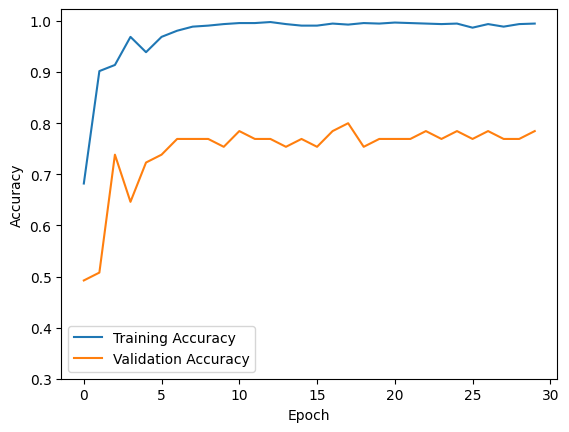

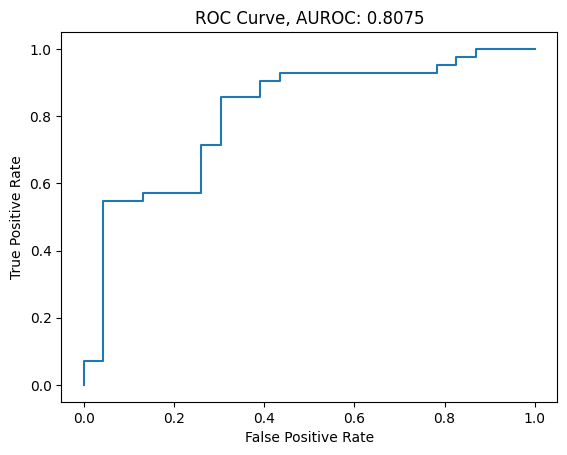

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# Main function
def main():
    num_epochs = 30

    accuracy_list = []
    loss_list = []
    val_accuracy_list = []
    val_loss_list = []

    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        val_loss, val_accuracy, loss, accuracy = train(model, train_loader, criterion, optimizer, best_loss)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        scheduler.step()

        accuracy_list.append(accuracy)
        loss_list.append(loss)
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss)

    print("Finished training")

    binary_string = 'binary'
    row_norm_string = 'quantile'

    # Plot the training and validation loss
    plt.figure()
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yticks([i/10 for i in range(0, 20, 2)])
    plt.legend()
    plt.savefig(f"../Results_one_PD/loss_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    plt.clf()
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.yticks([i/10 for i in range(3, 11, 1)])
    plt.legend()
    plt.savefig(f"../Results_one_PD/accuracy_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Load the model (best or latest)
    model.load_state_dict(torch.load('best_model_one_pipeline_PD.pth'))

    model.eval()
    y_pred = []
    y_true = []
    y_pred_prob = pd.DataFrame()

    with torch.no_grad():
        for (data1, labels) in val_loader:

            outputs = model(data1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).numpy())
            y_pred_prob = pd.concat([y_pred_prob, pd.DataFrame(outputs.softmax(dim=1))], ignore_index=True)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig(f"../Results_one_PD/confusion_matrix_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    # Plot ROC curve with thresholds from 0.1 to 0.9
    plt.clf()
    # Calculate the AUROC score
    fpr, tpr, thresholds = roc_curve(pd.DataFrame(y_true), y_pred_prob[1])
    print("Best cutoff threshold: ", thresholds[np.argmax(tpr - fpr)])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUROC: {:.4f}'.format(roc_auc_score(pd.DataFrame(y_true), y_pred_prob[1])))
    plt.savefig(f"../Results_one_PD/roc_curve_{binary_string}_{row_norm_string}_{num_epochs}_.png")

    


if __name__ == '__main__':
    main()